In [1]:
# ! pip install mecab

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
ㅊimport urllib.request
import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings(action='ignore')

# 데이터 로드

## 뉴스

In [3]:
ticker = pd.read_csv('../기업ticker.csv')
ticker.head(3)

,Unnamed: 0,ticker
0,CMG제약,58820
1,HLB,28300
2,HLB생명과학,67630


In [3]:
import os

filelist = os.listdir('../데이터/기업별_뉴스/18-22')

In [4]:
filelist[:5]

['DeepSearch-CMG제약-news-2018-01-01-2018-12-31-20230601-191902.xlsx',
 'DeepSearch-CMG제약-news-2019-01-01-2019-12-31-20230601-192349.xlsx',
 'DeepSearch-CMG제약-news-2020-01-01-2020-12-31-20230601-192831.xlsx',
 'DeepSearch-CMG제약-news-2021-01-01-2021-12-31-20230601-193311.xlsx',
 'DeepSearch-CMG제약-news-2022-01-01-2022-12-31-20230601-193756.xlsx']

In [6]:
df_all = []
for name in filelist:
    df =pd.read_excel(f"../데이터/기업별_뉴스/18-22/{name}",sheet_name='#02 Documents',header=0)
    df_all.append(df)

In [7]:
df_all[0].tail(2)

,date,category,section,publisher,author,title,content_url,attachment,industry.label,industry.score,industry.name,polarity.label,polarity.score,polarity.name
98,2018-01-02,news,economy,파이낸셜뉴스,NaN,[fnRASSI]CMG제약 전일대비 9.13% 상승,NaN,NaN,100,0.982,"분류 제외, 기타",1.0,0.993,긍정
99,2018-01-02,news,economy,서울경제,NaN,"(코)CMG제약, 전일 대비 7.21% 상승.. 일일회전율은 4.61% 기록",NaN,NaN,C21,1.000,의료용 물질 및 의약품 제조업,1.0,0.995,긍정


In [8]:
# df_all[0][df_all[0]['polarity.name'].isna()]

In [8]:
label_X = []
label_O = []
for df in df_all:
    tmp_X=df[df['polarity.name'].isna()]
    tmp_O=df[df['polarity.name'].notna()]
    label_X.append(tmp_X)
    label_O.append(tmp_O)    

In [10]:
# label_O[0]

In [9]:
label_OO = pd.concat(label_O, axis=0)


In [10]:
len(label_OO)

41590

In [11]:
label_OO.head(2)

,date,category,section,publisher,author,title,content_url,attachment,industry.label,industry.score,industry.name,polarity.label,polarity.score,polarity.name
0,2018-12-27,news,economy,전자신문,NaN,[ET투자뉴스]CMG제약_기관의 힘? 대량순매수 이후.. 현재 +3.05%,NaN,NaN,C21,1.00,의료용 물질 및 의약품 제조업,1.0,0.643,긍정
1,2018-12-24,news,economy,한국경제,NaN,[한경로보뉴스] '와이지엔터테인먼트' 52주 신고가 경신,NaN,NaN,C26,0.59,"전자 부품, 컴퓨터, 영상, 음향 및 통신장비 제조업",1.0,0.667,긍정


In [17]:
# label_OO[10:20]

In [12]:

label_OO['polarity.label'] = label_OO['polarity.label'].replace([0, 1, -1],[0, 1, 2])
# label_OO[10:20]

In [13]:
duplicate = label_OO[label_OO.duplicated()]
# duplicate.head(2)

In [14]:
label_OO.drop_duplicates(subset=['title'], inplace=True)

In [15]:
len(label_OO)

36480

In [16]:
mecab = mecab.MeCab()

In [17]:
label_OO['tokenized'] = label_OO['title'].apply(mecab.morphs)

In [18]:
label_OO.head(2)

,date,category,section,publisher,author,title,content_url,attachment,industry.label,industry.score,industry.name,polarity.label,polarity.score,polarity.name,tokenized
0,2018-12-27,news,economy,전자신문,NaN,[ET투자뉴스]CMG제약_기관의 힘? 대량순매수 이후.. 현재 +3.05%,NaN,NaN,C21,1.00,의료용 물질 및 의약품 제조업,1.0,0.643,긍정,"[[, ET, 투자, 뉴스, ], CMG, 제약, _, 기관, 의, 힘, ?, 대량..."
1,2018-12-24,news,economy,한국경제,NaN,[한경로보뉴스] '와이지엔터테인먼트' 52주 신고가 경신,NaN,NaN,C26,0.59,"전자 부품, 컴퓨터, 영상, 음향 및 통신장비 제조업",1.0,0.667,긍정,"[[, 한경, 로보, 뉴스, ], ', 와, 이지, 엔터, 테, 인, 먼, 트, '..."


In [29]:
label_OO = label_OO.iloc[:,[5,11,14]]

In [31]:
label_OO.columns = ['kor_sentence','labels','tokenized']

In [33]:
label_OO = label_OO[['labels','kor_sentence','tokenized']]

In [34]:
label_OO.head()

,labels,kor_sentence,tokenized
0,1.0,[ET투자뉴스]CMG제약_기관의 힘? 대량순매수 이후.. 현재 +3.05%,"[[, ET, 투자, 뉴스, ], CMG, 제약, _, 기관, 의, 힘, ?, 대량..."
1,1.0,[한경로보뉴스] '와이지엔터테인먼트' 52주 신고가 경신,"[[, 한경, 로보, 뉴스, ], ', 와, 이지, 엔터, 테, 인, 먼, 트, '..."
2,1.0,"CMG제약(058820) 종목알파고 분석, 외국인/기관 실시간 수급과 추가 매수 확률은?","[CMG, 제약, (, 058820, ), 종목, 알파, 고, 분석, ,, 외국인,..."
3,0.0,"CMG제약, 전일 대비 약 -4% 하락한 4,515원","[CMG, 제약, ,, 전일, 대비, 약, -, 4, %, 하락, 한, 4, ,, ..."
6,1.0,[Hot Stock] CMG제약,"[[, Hot, Stock, ], CMG, 제약]"


## fin

In [19]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x206f64c3580>)

In [20]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [21]:
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
data[:5]

,labels,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [22]:
del data['sentence']

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   int64 
 1   kor_sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [24]:
duplicate = data[data.duplicated()]

In [25]:
# 중복 제거
data.drop_duplicates(subset=['kor_sentence'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4827


In [26]:
data['tokenized'] = data['kor_sentence'].apply(mecab.morphs)

In [27]:
data.head()

,labels,kor_sentence,tokenized
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...","[Gran, 에, 따르, 면, ,, 그, 회사, 는, 회사, 가, 성장, 하, 고,..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...,"[테크노폴리스, 는, 컴퓨터, 기술, 과, 통신, 분야, 에서, 일, 하, 는, 회..."
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ...","[국제, 전자, 산업, 회사, 인, 엘코, 텍, 은, 탈린, 공장, 에서, 수십, ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...,"[새로운, 생산, 공장, 으로, 인해, 회사, 는, 예상, 되, 는, 수요, 증가,..."
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4...","[2009, -, 2012, 년, 회사, 의, 업데이트, 된, 전략, 에, 따르, ..."


## concat

In [36]:
df = pd.concat([label_OO,data])
len(df)

41307

In [57]:
df.to_csv('./lable18_22.csv', index = False)

In [38]:
print(f'중립의 비율 = {round(df["labels"].value_counts()[0]/len(df) * 100,3)}%')
print(f'긍정의 비율 = {round(df["labels"].value_counts()[1]/len(df) * 100,3)}%')
print(f'부정의 비율 = {round(df["labels"].value_counts()[2]/len(df) * 100,3)}%')

중립의 비율 = 38.044%
긍정의 비율 = 51.086%
부정의 비율 = 10.87%


# 훈련 - 테스트

In [39]:
X = df['tokenized']
y = df['labels']
print('본문의 개수: {}'.format(len(X)))
print('레이블의 개수: {}'.format(len(y)))

본문의 개수: 41307
레이블의 개수: 41307


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# tokenize

In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[141, 1, 693, 849, 175, 303], [141, 1, 767, 50, 3, 1681, 1993, 1161, 3, 552, 755, 709, 78, 57, 121], [23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 12726, 12727, 9434, 1, 369, 36, 18, 59, 252, 25, 373, 9435, 4063, 143, 6598, 1292, 3238, 11, 985, 12728, 12729, 13, 4824, 4064, 12730, 4825, 304, 56, 144, 40, 47, 1], [4, 45, 14, 5, 3, 5861, 737, 919, 1215, 256, 14, 3, 413, 48, 69, 7, 17], [3, 174, 815, 738, 800, 3, 53, 7, 73, 17, 1, 216, 21, 284, 10, 190, 117, 505, 166, 28, 241]]
[[116, 346, 1, 1125, 169, 131, 80, 8, 80, 865, 18, 148, 114, 1702, 75, 114], [119, 48, 3, 1523, 5158, 3, 1071, 6, 29, 493, 28, 3982, 778, 28, 21, 10634, 2976, 4, 239, 29, 6652, 5], [4, 746, 55, 79, 5, 20, 380, 25, 27, 7316, 42], [163, 83, 86, 1, 687, 199, 108, 936, 564, 1272, 139, 187, 6, 122], [652, 24, 1, 324, 43, 62, 54, 151, 1234, 22, 8, 571, 318]]


In [43]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

22884


## 패딩

In [28]:
X_train[:2]

2049    [보험, 사, 는, 노르, 데, 아, 의, 순이익, 에서, 노르, 데, 아가, 차지...
129     [백화점, 부서, 는, 매출, 이, 4, %, 증가, 했, 다고, 보, 고, 했, ...
Name: tokenized, dtype: object

본문의 최대 길이 : 76
본문의 평균 길이 : 17.334362233318203


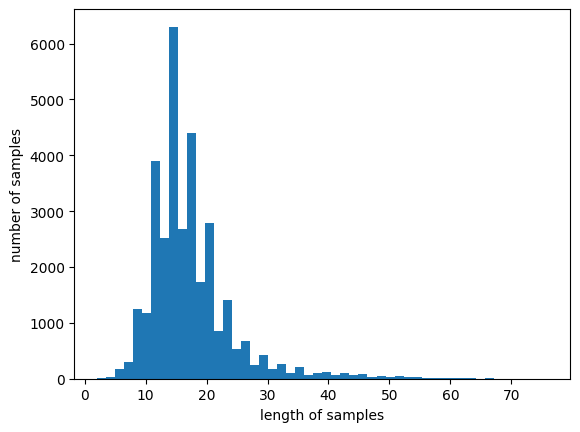

In [44]:
print(  '본문의 최대 길이 :',   max(   len(sent) for sent in X_train   )   )
# X_train 요소 하나하나 길이 재서 최대길이추출
print(   '본문의 평균 길이 :',  sum(    map(len, X_train)  )   /  len(X_train)     )
# X_train 요소 길이 재서 sum하구 X_train 개수로 나눈다
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [45]:
max_len = 76

In [46]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [47]:
X_train_encoded.shape

(33045, 76)

In [48]:
X_test_encoded.shape

(8262, 76)

In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [50]:
X_test[:1]

30    [코, 넥스, ,, 98, 개, 종목, 거래, …, 거래, 대금, 1, 위, `, ...
Name: tokenized, dtype: object

In [51]:
X_train_encoded[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0, 141,   1, 693, 849, 175, 303])

In [52]:
X_train_encoded.shape

(33045, 76)

In [ ]:
y_test[8]

In [53]:
y_train.shape

(33045,)

In [54]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [44]:
y_train.shape

(3861, 3)

 * 테스트 정확도: 0.8574

In [55]:
embedding_dim = 64
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./NLP/3.best_model_18_22.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
826/827 [============================>.] - ETA: 0s - loss: 0.4891 - acc: 0.7957
Epoch 1: val_acc improved from -inf to 0.85399, saving model to ./NLP\3.best_model_18_22.h5
827/827 [==============================] - 33s 34ms/step - loss: 0.4890 - acc: 0.7957 - val_loss: 0.3558 - val_acc: 0.8540
Epoch 2/15
827/827 [==============================] - ETA: 0s - loss: 0.2422 - acc: 0.9058
Epoch 2: val_acc improved from 0.85399 to 0.85611, saving model to ./NLP\3.best_model_18_22.h5
827/827 [==============================] - 28s 34ms/step - loss: 0.2422 - acc: 0.9058 - val_loss: 0.3700 - val_acc: 0.8561
Epoch 3/15
827/827 [==============================] - ETA: 0s - loss: 0.1610 - acc: 0.9411
Epoch 3: val_acc did not improve from 0.85611
827/827 [==============================] - 30s 36ms/step - loss: 0.1610 - acc: 0.9411 - val_loss: 0.3981 - val_acc: 0.8555
Epoch 4/15
826/827 [============================>.] - ETA: 0s - loss: 0.1156 - acc: 0.9586
Epoch 4: val_acc did not improve f

In [56]:
loaded_model = load_model('./NLP/3.best_model_18_22.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_encoded, y_test)[1]))

259/259 [==============================] - 3s 8ms/step - loss: 0.3782 - acc: 0.8574

 테스트 정확도: 0.8574


In [ ]:
loaded_model